In [64]:
import os
import sys
import gc
import math
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from tqdm import tqdm
from sklearn import preprocessing

from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
%matplotlib inline

from itertools import product

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [65]:
DATA_FOLDER = './input/'

sales           = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
test            = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))

In [66]:
print(sales.shape)
print(sales.head())

print(items.shape)
print(items.head())

print(item_categories.shape)
print(item_categories.head())

print(shops.shape)
print(shops.head())

print(test.shape)
print(test.head())

(2935849, 6)
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
(22170, 3)
                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  
(84, 2)
 

In [8]:
# prepare date
sales['date'] = pd.to_datetime(sales['date'], format = '%d.%m.%Y')

sales['month'] = sales['date'].dt.month
sales['year'] = sales['date'].dt.year

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()
sales = pd.merge(sales, item_category_mapping, how='left', on='item_id')

the number of shop_id:  42
the number of item_id:  5100


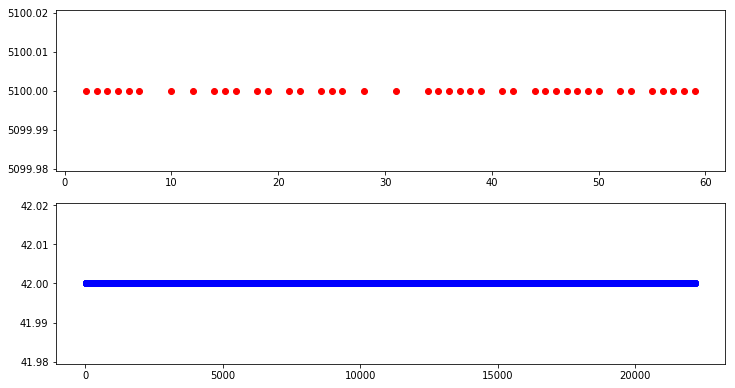

In [11]:
print("the number of shop_id: ", test['shop_id'].unique().size)
print("the number of item_id: ", test['item_id'].unique().size)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6.5))
ax1.get_yaxis().get_major_formatter().set_useOffset(False)
ax2.get_yaxis().get_major_formatter().set_useOffset(False)

x = test['shop_id'].value_counts().index
y = test['shop_id'].value_counts().values
ax1.scatter(x, y, c = 'r')

x = test['item_id'].value_counts().index
y = test['item_id'].value_counts().values
ax2.scatter(x, y, c = 'b')

so test_data just look through all combine with item_id and shop_id

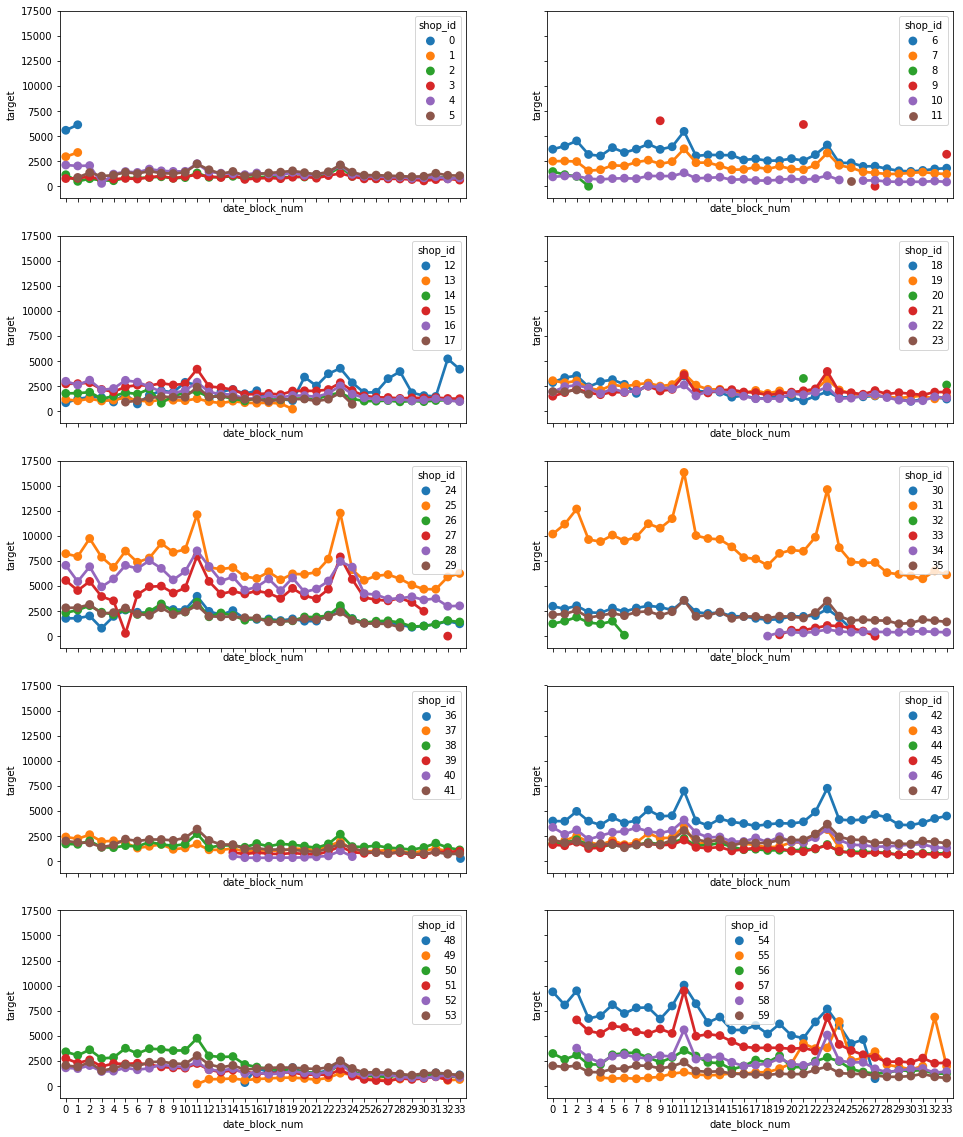

In [50]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))


index_col = 'date_block_num'
feature_col = 'shop_id'

gb = sales.groupby([index_col, feature_col],as_index=False).agg({'item_cnt_day':{'target':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]


count = 0
num_graph = 10
num_per_graph = math.ceil(sales[feature_col].max() / num_graph)

for i in range(5):
    for j in range(2):
        data = gb[np.logical_and(count*num_per_graph <= gb[feature_col], gb[feature_col] < (count+1)*num_per_graph)]
        sns.pointplot(x=index_col, y='target', hue=feature_col, 
                      data=data, 
                      ax=axes[i][j])
        count += 1

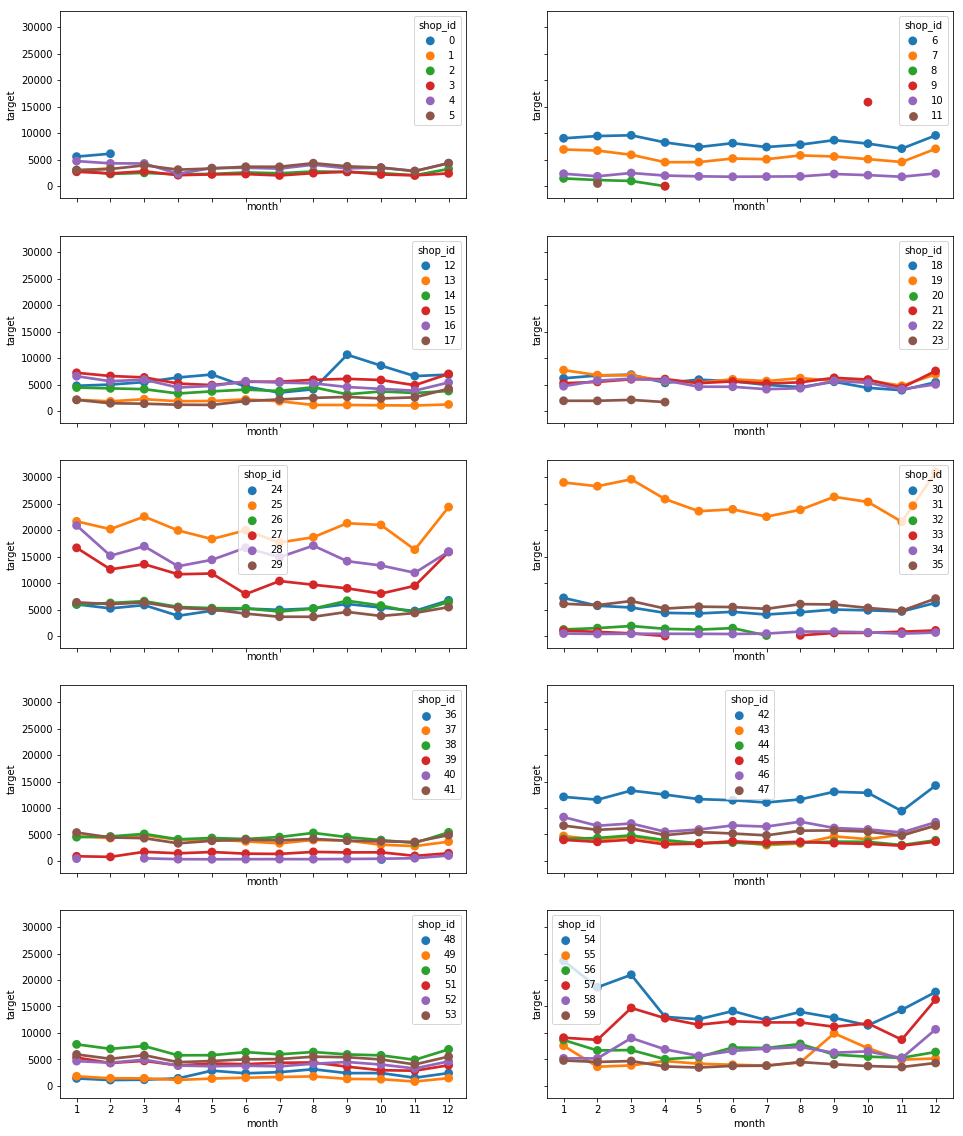

In [51]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))

index_col = 'month'
feature_col = 'shop_id'

gb = sales.groupby([index_col, feature_col],as_index=False).agg({'item_cnt_day':{'target':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]


count = 0
num_graph = 10
num_per_graph = math.ceil(sales[feature_col].max() / num_graph)

for i in range(5):
    for j in range(2):
        data = gb[np.logical_and(count*num_per_graph <= gb[feature_col], gb[feature_col] < (count+1)*num_per_graph)]
        sns.pointplot(x=index_col, y='target', hue=feature_col, 
                      data=data, 
                      ax=axes[i][j])
        count += 1

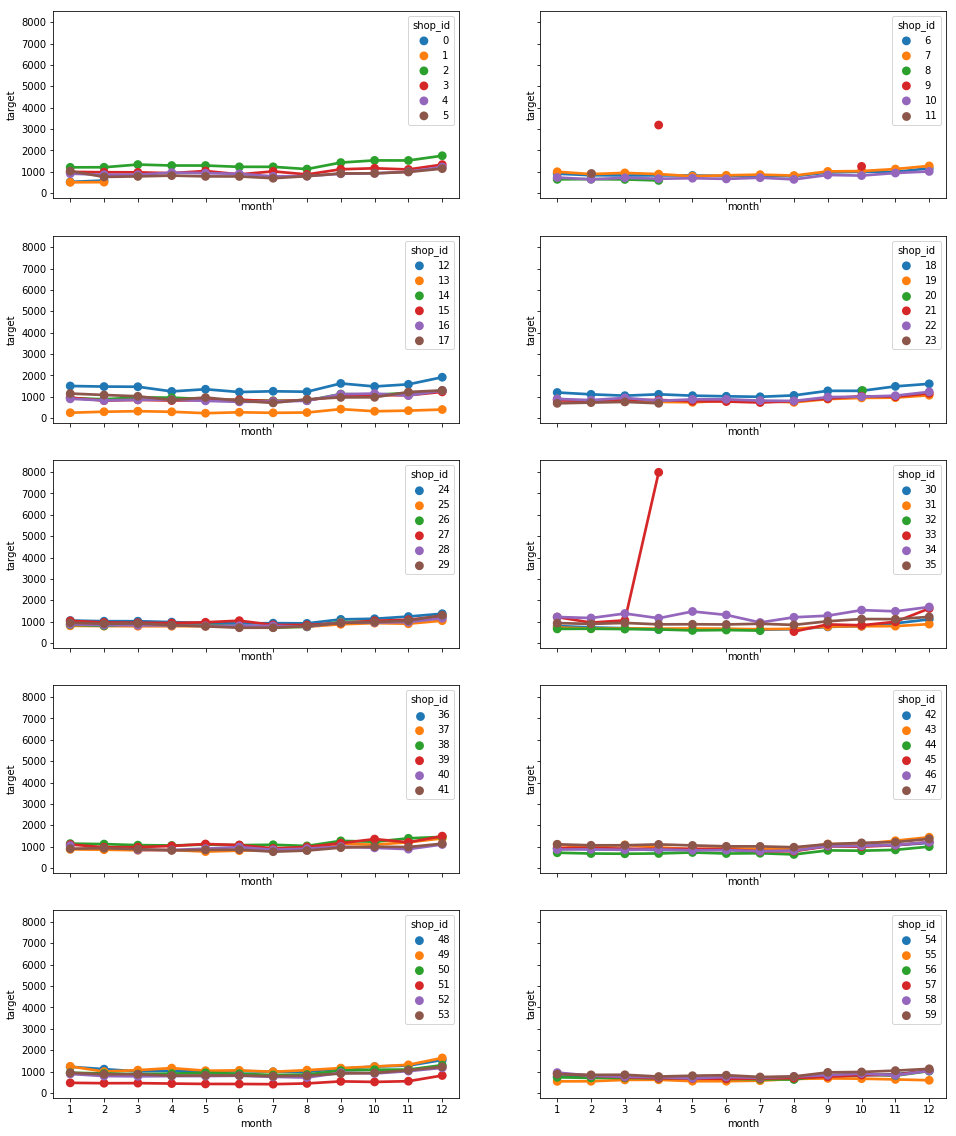

In [54]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))

index_col = 'month'
feature_col = 'shop_id'

gb = sales.groupby([index_col, feature_col],as_index=False).agg({'item_price':{'target':'mean'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]

count = 0
num_graph = 10
num_per_graph = math.ceil(sales[feature_col].max() / num_graph)

for i in range(5):
    for j in range(2):
        data = gb[np.logical_and(count*num_per_graph <= gb[feature_col], gb[feature_col] < (count+1)*num_per_graph)]
        sns.pointplot(x=index_col, y='target', hue=feature_col, 
                      data=data, 
                      ax=axes[i][j])
        count += 1

We find there is a peak at the end of the year, maybe there is a big holiday. we can add month and year to fit better. And item_price look like fluctuating with sales, we also add price features

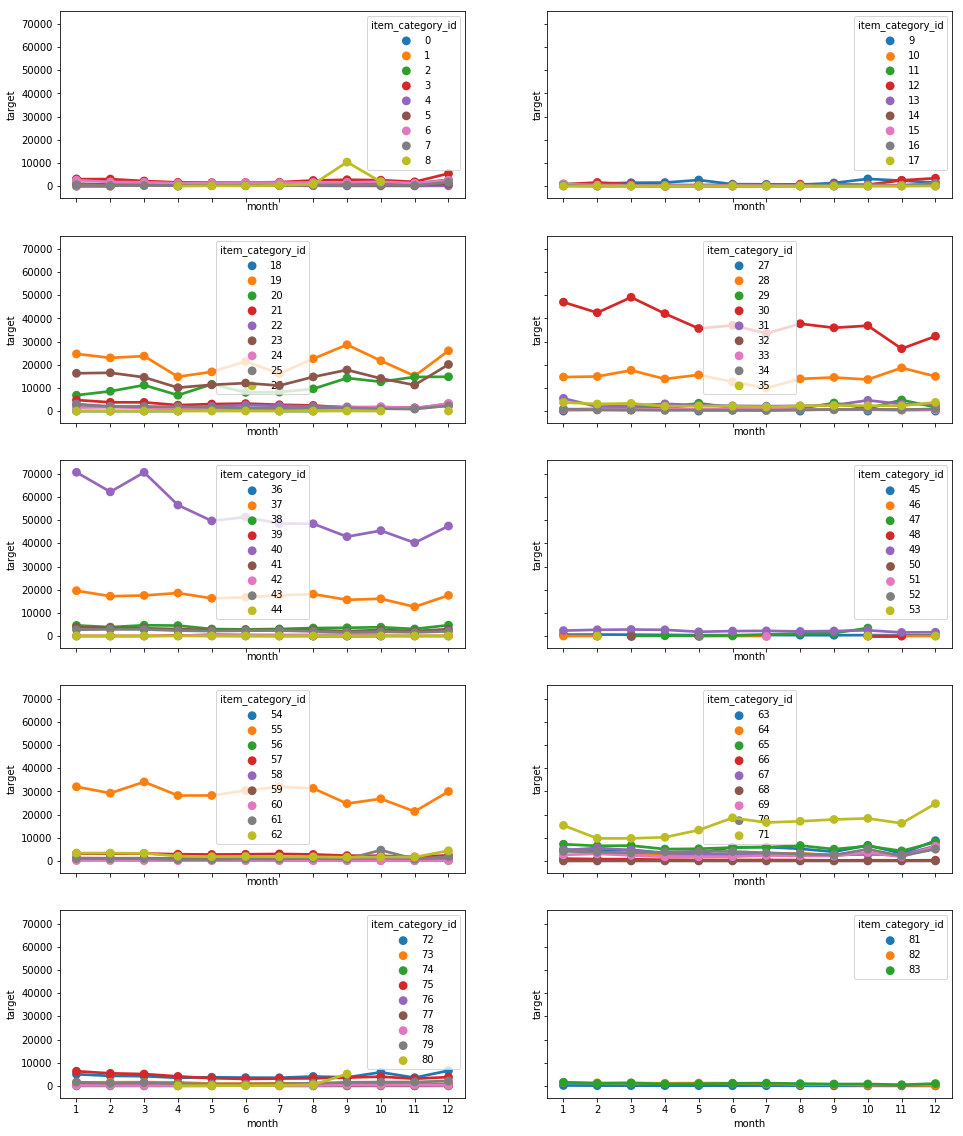

In [55]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))

index_col = 'month'
feature_col = 'item_category_id'

gb = sales.groupby([index_col, feature_col],as_index=False).agg({'item_cnt_day':{'target':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]


count = 0
num_graph = 10
num_per_graph = math.ceil(sales[feature_col].max() / num_graph)

for i in range(5):
    for j in range(2):
        data = gb[np.logical_and(count*num_per_graph <= gb[feature_col], gb[feature_col] < (count+1)*num_per_graph)]
        sns.pointplot(x=index_col, y='target', hue=feature_col, 
                      data=data, 
                      ax=axes[i][j])
        count += 1

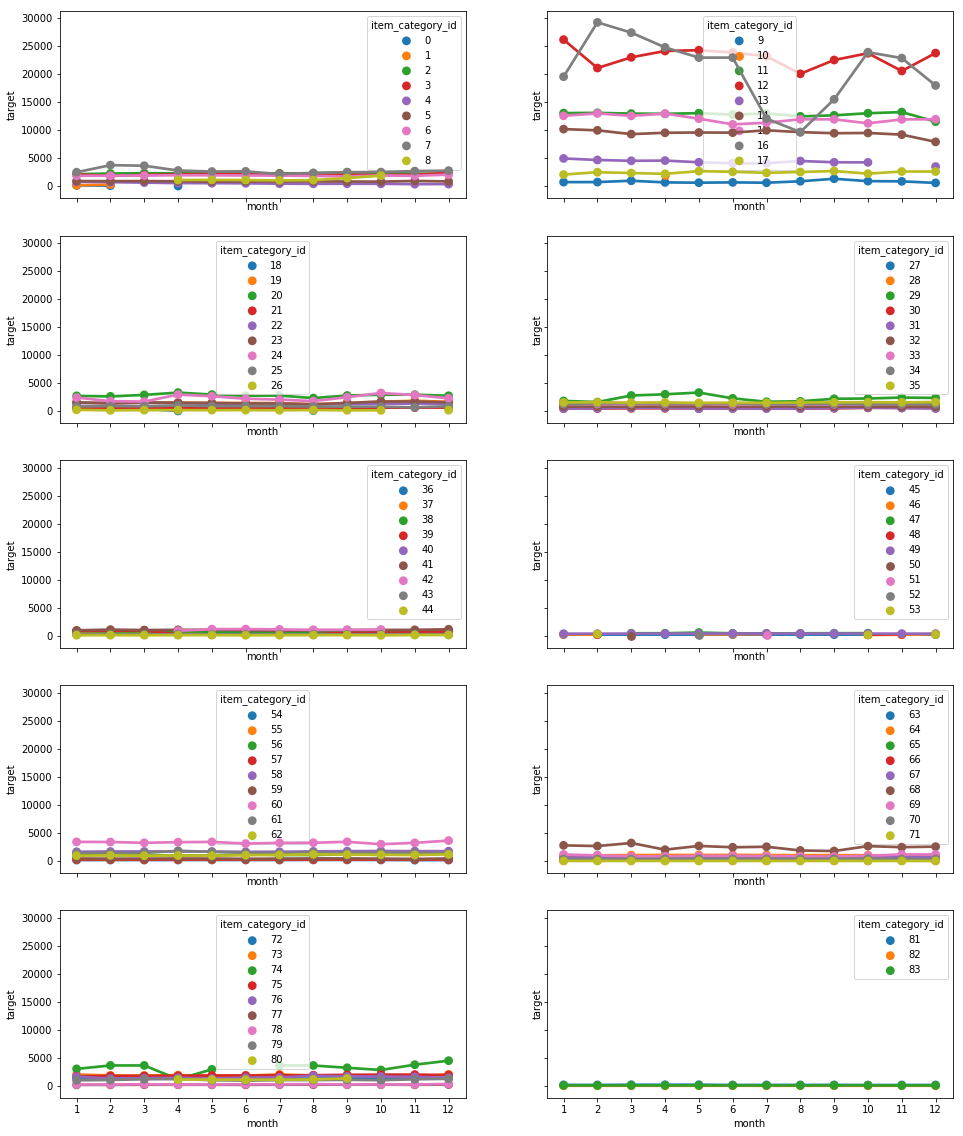

In [53]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))

index_col = 'month'
feature_col = 'item_category_id'

gb = sales.groupby([index_col, feature_col],as_index=False).agg({'item_price':{'target':'mean'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]


count = 0
num_graph = 10
num_per_graph = math.ceil(sales[feature_col].max() / num_graph)

for i in range(5):
    for j in range(2):
        data = gb[np.logical_and(count*num_per_graph <= gb[feature_col], gb[feature_col] < (count+1)*num_per_graph)]
        sns.pointplot(x=index_col, y='target', hue=feature_col, 
                      data=data, 
                      ax=axes[i][j])
        count += 1

In [15]:
sub_sales = sales.loc[sales.item_id < 500].copy()

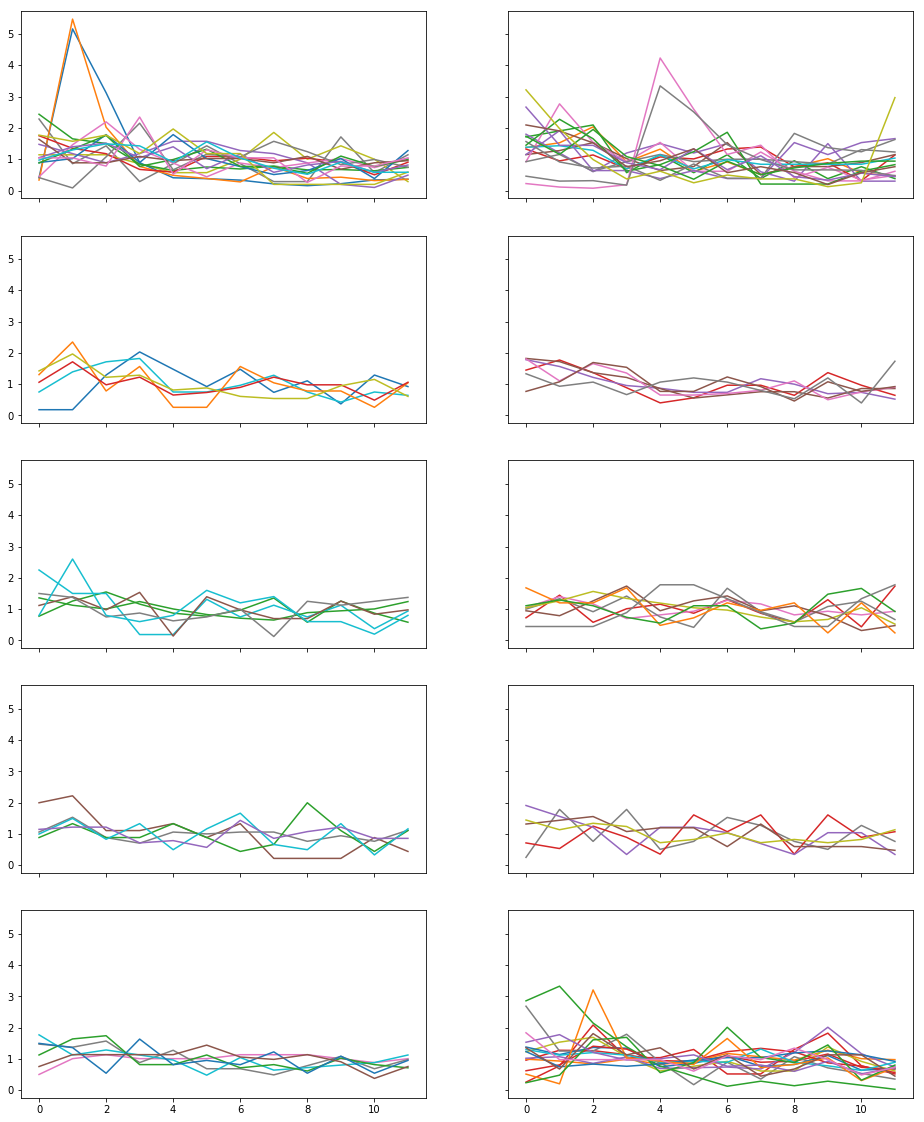

In [23]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))

index_col = 'month'
feature_col = 'item_id'

gb = sub_sales.groupby([index_col, feature_col],as_index=False).agg({'item_cnt_day':{'target':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]

count = 0
num_graph = 10
num_per_graph = math.ceil(sub_sales[feature_col].max() / num_graph)

for i in range(5):
    for j in range(2):
        data = gb[np.logical_and(count*num_per_graph <= gb[feature_col], gb[feature_col] < (count+1)*num_per_graph)]
        agg_month_item = pd.pivot_table(data, index=index_col, columns=feature_col,
                               values='target', aggfunc=np.mean).values
        axes[i][j].plot(agg_month_item / agg_month_item.mean(0)[np.newaxis])
        count += 1

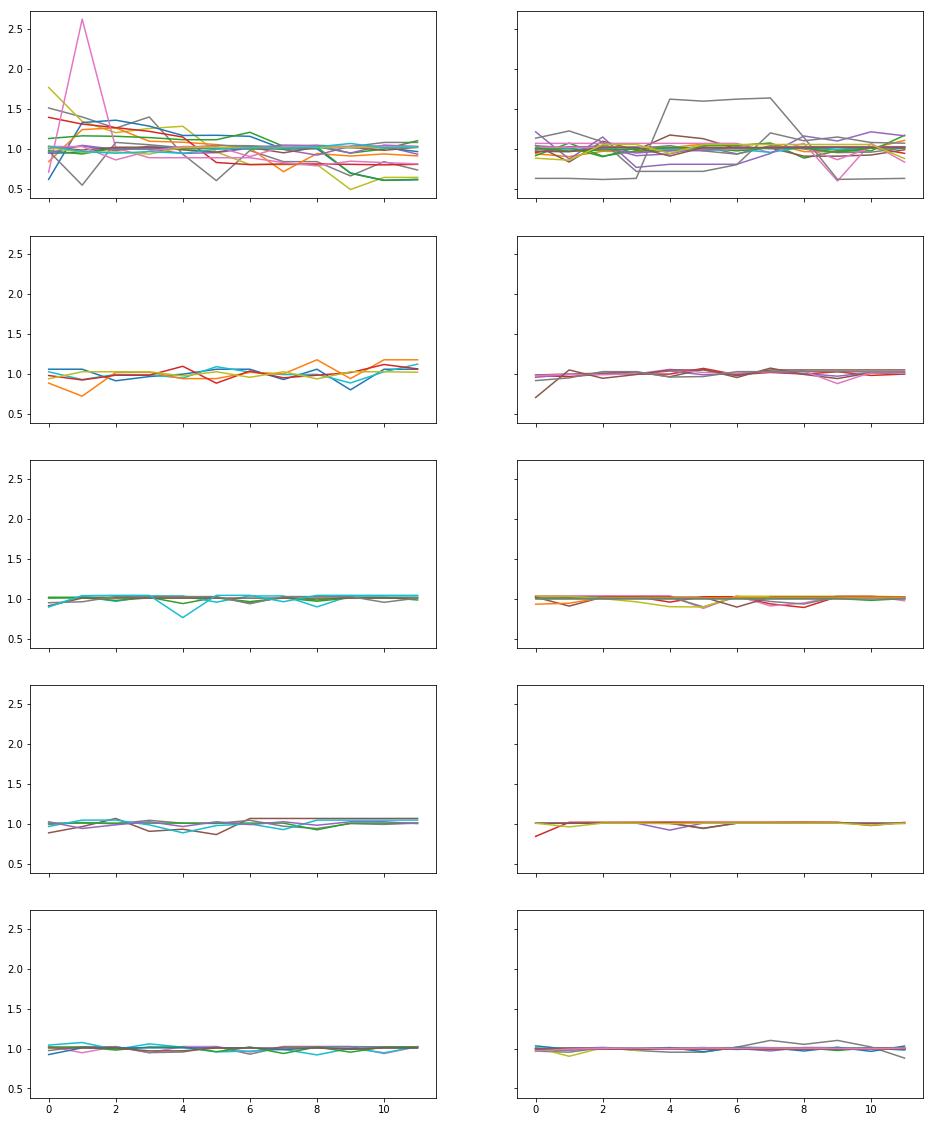

In [25]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))

index_col = 'month'
feature_col = 'item_id'

gb = sub_sales.groupby([index_col, feature_col],as_index=False).agg({'item_price':{'target':'mean'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]


count = 0
num_graph = 10
num_per_graph = math.ceil(sub_sales[feature_col].max() / num_graph)

for i in range(5):
    for j in range(2):
        data = gb[np.logical_and(count*num_per_graph <= gb[feature_col], gb[feature_col] < (count+1)*num_per_graph)]
        agg_month_item = pd.pivot_table(data, index=index_col, columns=feature_col,
                               values='target', aggfunc=np.mean).values
        axes[i][j].plot(agg_month_item / agg_month_item.mean(0)[np.newaxis])
        count += 1

In [26]:
del sub_sales

In [27]:
# Aggregate dat
index_cols = ['shop_id', 'item_id', 'date_block_num']

grid = [] 
# add missing values acorrding to the distribution of test_data
for block_num in sales['date_block_num'].unique():
    cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})

gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]

all_data = pd.merge(grid,gb,how='left',on=index_cols).fillna(0)

all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

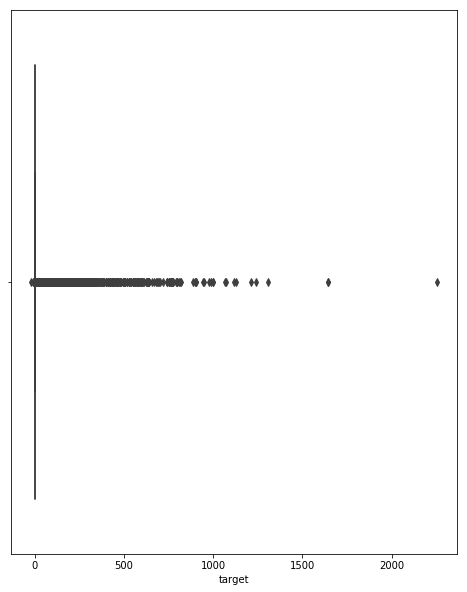

In [36]:
fig, ax = plt.subplots(figsize=(8,10))
sns.boxplot(x=all_data['target'], ax=ax)

In [49]:
tmp_target = all_data['target'].copy()

counts = tmp_target.value_counts(normalize=True)
print(counts)
print(np.sum(counts[0:20].values))

del tmp_target

 0.0      8.527980e-01
 1.0      9.701663e-02
 2.0      2.432707e-02
 3.0      9.458349e-03
 4.0      4.886177e-03
 5.0      2.929672e-03
 6.0      1.899513e-03
 7.0      1.288271e-03
 8.0      9.556664e-04
 9.0      6.908653e-04
 10.0     5.509513e-04
 11.0     4.107625e-04
 12.0     3.403015e-04
 13.0     2.795530e-04
 14.0     2.243021e-04
 15.0     1.902170e-04
 16.0     1.603467e-04
 17.0     1.444953e-04
 18.0     1.188398e-04
 19.0     1.016140e-04
 20.0     9.428387e-05
-1.0      8.090637e-05
 21.0     7.623341e-05
 22.0     6.587959e-05
 23.0     6.120663e-05
 24.0     4.929516e-05
 25.0     4.801239e-05
 26.0     4.352268e-05
 27.0     3.921623e-05
 28.0     3.738369e-05
              ...     
 422.0    9.162669e-08
 423.0    9.162669e-08
 426.0    9.162669e-08
 430.0    9.162669e-08
 431.0    9.162669e-08
 432.0    9.162669e-08
 434.0    9.162669e-08
 441.0    9.162669e-08
 380.0    9.162669e-08
 378.0    9.162669e-08
 375.0    9.162669e-08
 374.0    9.162669e-08
 331.0    9

In [ ]:
# remove outlier...
all_data['target'] = all_data['target'].clip(0, 20)

## Feature engineering

In [ ]:
# add mean_item_price
index_cols = ['item_id', 'date_block_num']
simple_sales = sales[index_cols + ['item_price']].copy()

simple_sales['mean_item_price'] = \
    simple_sales.groupby(index_cols)['item_price'].transform('mean')

simple_sales = simple_sales.drop('item_price', axis=1).drop_duplicates()

all_data = pd.merge(all_data, simple_sales, on=index_cols, how='left').fillna(0)

del simple_sales

In [ ]:
# add mean_shop_item_price
index_cols = ['shop_id', 'item_id', 'date_block_num']
simple_sales = sales[index_cols + ['item_price']].copy()

simple_sales['mean_item_shop_price'] = \
    simple_sales.groupby(index_cols)['item_price'].transform('mean')

simple_sales = simple_sales.drop('item_price', axis=1).drop_duplicates()

all_data = pd.merge(all_data, simple_sales, on=index_cols, how='left').fillna(0)

del simple_sales

In [ ]:
# add item_name tf-idf
items_subset = items[['item_id', 'item_name']]
feature_count = 25
tfidf = TfidfVectorizer(max_features=feature_count)
items_df_item_name_text_features = pd.DataFrame(tfidf.fit_transform(items_subset['item_name']).toarray())

cols = items_df_item_name_text_features.columns
for i in range(feature_count):
    feature_name = 'item_name_tfidf_' + str(i)
    items_subset[feature_name] = items_df_item_name_text_features[cols[i]]

items_subset.drop('item_name', axis = 1, inplace = True)

all_data = all_data.merge(items_subset, on = 'item_id', how = 'left')
test = test.merge(items_subset, on = 'item_id', how = 'left')

In [ ]:
# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
test = pd.merge(test, item_category_mapping, how='left', on='item_id')

# Fix category
l_cat = list(item_categories.item_category_name)

for ind in range(0,1):
    l_cat[ind] = 'PC Headsets / Headphones'
    
for ind in range(1,8):
    l_cat[ind] = 'Access'
    
l_cat[8] = 'Tickets (figure)'

l_cat[9] = 'Delivery of goods'

for ind in range(10,18):
    l_cat[ind] = 'Consoles'
    
for ind in range(18,25):
    l_cat[ind] = 'Consoles Games'
    
l_cat[25] = 'Accessories for games'

for ind in range(26,28):
    l_cat[ind] = 'phone games'
    
for ind in range(28,32):
    l_cat[ind] = 'CD games'
    
for ind in range(32,37):
    l_cat[ind] = 'Card'
    
for ind in range(37,43):
    l_cat[ind] = 'Movie'
    
for ind in range(43,55):
    l_cat[ind] = 'Books'
    
for ind in range(55,61):
    l_cat[ind] = 'Music'
    
for ind in range(61,73):
    l_cat[ind] = 'Gifts'
    
for ind in range(73,79):
    l_cat[ind] = 'Soft'
    
for ind in range(79,81):
    l_cat[ind] = 'Office'
    
for ind in range(81,83):
    l_cat[ind] = 'Clean'
    
l_cat[83] = 'Elements of a food'

lb = preprocessing.LabelEncoder()
item_categories['item_category_id_fix'] = lb.fit_transform(l_cat)
item_categories['item_category_name_fix'] = l_cat

fix_cat_mapping = item_categories[['item_category_id', 'item_category_id_fix']]

all_data = all_data.merge(fix_cat_mapping, on = 'item_category_id', how = 'left')
test = test.merge(fix_cat_mapping, on = 'item_category_id', how = 'left')

In [ ]:
# reduce memory usage
all_data = downcast_dtypes(all_data)
test = downcast_dtypes(test)

In [ ]:
# add date_block_num for test
test['date_block_num'] = 34

In [ ]:
# create all kind of mean target
all_data['target_item'] = all_data.groupby(['date_block_num', 'item_id'])['target'].transform('mean')
all_data['target_shop'] = all_data.groupby(['date_block_num', 'shop_id'])['target'].transform('mean')

# categroy feature is important for me, it makes score increase 3% 
all_data['target_category'] = all_data.groupby(['date_block_num', 'item_category_id'])['target'].transform('mean')
all_data['target_shop_categroy'] = all_data.groupby(['date_block_num', 'shop_id', 'item_category_id'])['target'].transform('mean')

all_data['target_category_fix'] = all_data.groupby(['date_block_num', 'item_category_id_fix'])['target'].transform('mean')
all_data['target_shop_categroy_fix'] = all_data.groupby(['date_block_num', 'shop_id', 'item_category_id_fix'])['target'].transform('mean')

In [ ]:
tqdm.pandas(desc="my bar!")

def cal_interval(group):
    last_month = np.nan
    for idx, row in group.iterrows():
        group.loc[idx,'tmp_feature'] = group.loc[idx,'date_block_num']-last_month
        if group.loc[idx,'tmp_target'] > 0.0:
            last_month = group.loc[idx,'date_block_num']
    return group

def create_interval_feature(all_data, feature_cols, target_col):
    feature_name  = '_'.join(feature_cols)+"_month_diff"
    
    tmp_data = all_data[['date_block_num']+feature_cols+[target_col]].copy().drop_duplicates()
    
    tmp_data['tmp_feature'] = np.nan
    tmp_data.rename(columns = {target_col:'tmp_target'}, inplace = True)
    
    tmp_data = tmp_data.groupby(feature_cols).progress_apply(cal_interval)
    tmp_data['tmp_feature'].fillna(999, inplace=True)

    tmp_data = tmp_data.drop('tmp_target', axis=1)
    tmp_data.rename(columns = {'tmp_feature':feature_name}, inplace = True)
    
    all_data = pd.merge(all_data, tmp_data, on=['date_block_num']+feature_cols, how = 'left')
    
    del tmp_data
    
    return all_data

In [ ]:
# add difference between cur_date_block and last month with sales
all_data_with_test = pd.concat([all_data, test])
all_data_with_test.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

all_data_with_test = create_interval_feature(all_data_with_test, ['item_id'], 'target_item')
all_data_with_test = create_interval_feature(all_data_with_test, ['shop_id'], 'target_shop')
all_data_with_test = create_interval_feature(all_data_with_test, ['item_id', 'shop_id'], 'target')

all_data = all_data_with_test[all_data_with_test.date_block_num <= 33].copy()
test = all_data_with_test[all_data_with_test.date_block_num == 34].copy()

del all_data_with_test

In [62]:
shift_range = [1,2,3,5,12]

def target_lag(train_data, test_data, target_cols, feature_cols):
    print("start to encoding {} for {}".format(target_cols, feature_cols))
    feature_cols += ['date_block_num']
    
    for month_shift in tqdm_notebook(shift_range):
        train_shift = train_data[feature_cols + target_cols].copy().drop_duplicates()

        train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift

        foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in target_cols else x
        train_shift = train_shift.rename(columns=foo)
        
        train_data = pd.merge(train_data, train_shift, on=feature_cols, how='left').fillna(0)
        test_data = pd.merge(test_data, train_shift, on=feature_cols, how='left').fillna(0)
        
    del train_shift
    print(train_data.shape, test.shape)
    return train_data, test_data

In [ ]:
# add all kind of lag values
all_data, test = target_lag(all_data, test, ['target'], ['shop_id', 'item_id'])

all_data, test = target_lag(all_data, test, ['target_item'], ['item_id'])

all_data, test = target_lag(all_data, test, ['target_shop'], ['shop_id'])

all_data, test = target_lag(all_data, test, ['target_category'], ['item_category_id'])

all_data, test = target_lag(all_data, test, ['target_shop_categroy'], ['shop_id', 'item_category_id'])

all_data, test = target_lag(all_data, test, ['mean_item_price'], ['item_id'])

all_data, test = target_lag(all_data, test, ['mean_item_shop_price'], ['shop_id', 'item_id'])

In [ ]:
# create date features
all_data['month'] = all_data['date_block_num'] % 12
all_data['year'] = all_data['date_block_num'] // 12

test['month'] = test['date_block_num'] % 12
test['year'] = test['date_block_num'] // 12

## Modeling

In [114]:
all_data = all_data[all_data['date_block_num'] >= 12]

dates = all_data['date_block_num']
last_block = dates.max()

train_data = all_data.loc[dates <  last_block].copy()
val_data = all_data.loc[dates == last_block].copy()

to_drop_cols = ['ID', 'mean_item_price', 'mean_item_shop_price', 'target', 'target_item', \
                'target_shop', 'target_category', 'target_shop_categroy', \
                'target_category_fix', 'target_shop_categroy_fix'] + ['date_block_num']

to_drop_cols = set(to_drop_cols).intersection(set(train_data.columns))

X_train = train_data.drop(to_drop_cols, axis=1)
X_val =  val_data.drop(to_drop_cols, axis=1)

y_train = train_data['target'].values
y_val =  val_data['target'].values

In [115]:
X_train.head().T

,0,1,2,3,4
item_category_id,19.000000,40.000000,37.000000,40.000000,37.000000
item_id,27.000000,30.000000,31.000000,32.000000,33.000000
item_name_tfidf_0,0.000000,0.000000,0.000000,0.000000,0.000000
item_name_tfidf_1,0.000000,0.000000,0.000000,0.000000,0.000000
item_name_tfidf_10,0.000000,0.000000,0.000000,0.000000,0.000000
item_name_tfidf_11,0.000000,0.000000,0.000000,0.000000,0.000000
item_name_tfidf_12,0.000000,0.000000,0.000000,0.000000,0.000000
item_name_tfidf_13,0.685770,0.000000,0.000000,0.000000,0.000000
item_name_tfidf_14,0.000000,0.000000,0.000000,0.000000,0.000000
item_name_tfidf_15,0.000000,0.000000,0.000000,0.000000,0.000000


In [116]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [117]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

# This is better than defaults
params = {
    'random_seed': 73,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'min_data_in_leaf': 128,
    'num_leaves': 31,
    'learning_rate': 0.03,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.8,
    'bagging_freq': 3,
    'verbose': 0
}

In [118]:
print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=300,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

gbm.save_model('model.txt')

Starting training...
[1]	valid_0's rmse: 1.12544
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 1.11403
[3]	valid_0's rmse: 1.10382
[4]	valid_0's rmse: 1.09449
[5]	valid_0's rmse: 1.08556
[6]	valid_0's rmse: 1.07536
[7]	valid_0's rmse: 1.06595
[8]	valid_0's rmse: 1.05807
[9]	valid_0's rmse: 1.04942
[10]	valid_0's rmse: 1.04203
[11]	valid_0's rmse: 1.03451
[12]	valid_0's rmse: 1.02811
[13]	valid_0's rmse: 1.02215
[14]	valid_0's rmse: 1.01696
[15]	valid_0's rmse: 1.01107
[16]	valid_0's rmse: 1.00686
[17]	valid_0's rmse: 1.00158
[18]	valid_0's rmse: 0.996221
[19]	valid_0's rmse: 0.990843
[20]	valid_0's rmse: 0.985771
[21]	valid_0's rmse: 0.981565
[22]	valid_0's rmse: 0.976778
[23]	valid_0's rmse: 0.97321
[24]	valid_0's rmse: 0.969487
[25]	valid_0's rmse: 0.965584
[26]	valid_0's rmse: 0.961918
[27]	valid_0's rmse: 0.957897
[28]	valid_0's rmse: 0.95396
[29]	valid_0's rmse: 0.951052
[30]	valid_0's rmse: 0.948348
[31]	valid_0's rmse: 0.946009
[32]	valid_0's r

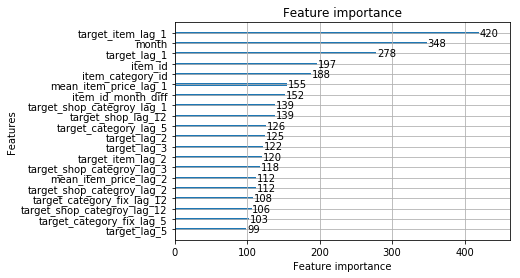

In [119]:
ax = lgb.plot_importance(gbm, max_num_features=20)
plt.show()

I didn't use ensemble tech, because it is not good as single gbdt model. Maybe I did something wrong

In [120]:
to_drop_cols = set(to_drop_cols).intersection(set(test.columns))
X_test = test.drop(to_drop_cols, axis=1)

cols_test = set(X_test.columns)
cols_train = set(X_train.columns)

print(cols_train-cols_test)
print(cols_test-cols_train)

set()
set()


In [121]:
print('Starting predicting on test dataset...')

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred = np.clip(y_pred, 0,20)

Starting predicting on test dataset...


In [122]:
submission = X_test.copy()

submission['item_cnt_month'] = y_pred
submission = submission[['shop_id', 'item_id', 'item_cnt_month']]

origin_test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))
submission = pd.merge(origin_test, submission, how='left', on=['shop_id', 'item_id'])

submission = submission[['ID', 'item_cnt_month']]
submission.to_csv('submission_all.csv', index=0)

print(submission.head())
print('Done')

   ID  item_cnt_month
0   0        0.586140
1   1        0.377017
2   2        0.948461
3   3        0.442712
4   4        5.697562
Done
